In [1]:
import sys
!pip install pandas
import pandas as pd
import numpy as np
import nltk


import re
import nltk
from joblib import dump, load
import matplotlib.pyplot as plt
pd.options.display.max_colwidth=200
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler  # Asegúrate de importar StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score




import scipy.stats as stats
import seaborn as sns; sns.set()  # for plot styling

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D # for 3D plots
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_error as mae


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree


from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold

# Metricas
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# q-q plots
import scipy.stats as stats

In [2]:
!pip install LightFM
from lightfm import LightFM
from lightfm.data import Dataset

## Carga de datos

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
pd2 = pd.read_csv('/content/drive/MyDrive/Corona/b2c_nuevo.csv' , sep=",", encoding="utf-8")

In [5]:

b2c = pd2.copy()

## Implementación B2C

In [6]:
b2c.columns

Index(['edad_promedio', 'ingreso_laboral_promedio', 'porcentaje_urbano',
       'IPUG', 'GINI', 'num_pedidos', 'categorias_diferentes',
       'Total de edificaciones en obra', 'pedido', 'id', 'edad', 'municipio',
       'asesor', 'punto de venta', 'cluster', 'categoria_macro', 'categoria',
       'subcategoria', 'producto', 'color', 'cantidad', 'precio', 'valor',
       'alineación con portafolio estratégico', 'log_cantidad', 'log_precio',
       'log_valor', 'ajustada_alineacion', 'total_productos', 'total_gasto',
       'precio_promedio', 'ticket_promedio', 'cantidad_promedio',
       'zona_AMAZONAS', 'zona_ANTIOQUIA', 'zona_ARAUCA', 'zona_ATLÁNTICO',
       'zona_BOGOTÁ', 'zona_BOLÍVAR', 'zona_BOYACA', 'zona_CALDAS',
       'zona_CAQUETA', 'zona_CASANARE', 'zona_CAUCA', 'zona_CESAR',
       'zona_CHOCO', 'zona_CUNDINAMARCA', 'zona_CÓRDOBA', 'zona_GUAINIA',
       'zona_GUAVIARE', 'zona_HUILA', 'zona_LA GUAJIRA', 'zona_MAGDALENA',
       'zona_META', 'zona_NARIÑO', 'zona_NORTE SANTA

In [ ]:
b2c = b2c.dropna(subset=['id', 'producto'])  


## Pipeline LightFM

In [8]:
from lightfm.data import Dataset

dataset = Dataset()

# USER features
user_features = (
    [f"cluster:{x}" for x in b2c['cluster'].astype(str).unique()] +
    [f"municipio:{x}" for x in b2c['municipio'].astype(str).unique()] +
    [f"asesor:{x}" for x in b2c['asesor'].astype(str).unique()] +
    [f"punto:{x}" for x in b2c['punto de venta'].astype(str).unique()] +
    b2c.columns[b2c.columns.str.startswith("zona_")].tolist()
)

# ITEM features
item_features = (
    [f"categoria_macro:{x}" for x in b2c['categoria_macro'].astype(str).unique()] +
    [f"subcategoria:{x}" for x in b2c['subcategoria'].astype(str).unique()] +
    [f"color:{x}" for x in b2c['color'].astype(str).unique()]
)

dataset.fit(
    users=b2c['id'].unique(),
    items=b2c['producto'].unique(),
    user_features=user_features,
    item_features=item_features
)


In [9]:

interactions, _ = dataset.build_interactions([
    (row['id'], row['producto']) for _, row in b2c.iterrows()
])


Ahora establecemos como se realiza la caracterización de los clientes y de los porductos

In [10]:
def construir_features_usuario(df):
    features = []
    for _, row in df.iterrows():
        f = [
            f"cluster:{row['cluster']}",
            f"municipio:{row['municipio']}",
            f"asesor:{row['asesor']}",
            f"punto:{row['punto de venta']}"
        ]
        for zona in df.columns[df.columns.str.startswith("zona_")]:
            if row[zona] == 1:
                f.append(zona)
        features.append((row['id'], f))
    return features


def construir_features_producto(df):
    features = []
    for _, row in df.iterrows():
        f = [
            f"categoria_macro:{row['categoria_macro']}",
            f"subcategoria:{row['subcategoria']}",
            f"color:{row['color']}"
        ]
        features.append((row['producto'], f))
    return features


user_features = dataset.build_user_features(construir_features_usuario(b2c))
item_features = dataset.build_item_features(construir_features_producto(b2c))


In [11]:
model = LightFM(loss='warp', no_components=16)
model.fit(interactions, user_features=user_features, item_features=item_features, epochs=5, num_threads=1)


In [ ]:
#Primeros 10 id de clientes
b2c['id'].dropna().unique()[:10]


array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [13]:
usuario_interno = dataset.mapping()[0][11]
scores = model.predict(usuario_interno, np.arange(len(dataset.mapping()[2])), user_features=user_features, item_features=item_features)
top_items = np.argsort(-scores)[:10]
productos = list(dataset.mapping()[2].keys())
print("Recomendaciones:", [productos[i] for i in top_items])


Recomendaciones: ['producto_59', 'producto_171', 'producto_130', 'producto_831', 'producto_681', 'producto_1116', 'producto_1508', 'producto_3', 'producto_119', 'producto_830']


In [39]:
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

# Calcular métricas usando el conjunto completo de interacciones
precision_lfm = precision_at_k(model, interactions, user_features=user_features, item_features=item_features, k=5).mean()
recall_lfm = recall_at_k(model, interactions, user_features=user_features, item_features=item_features, k=5).mean()
auc_lfm = auc_score(model, interactions, user_features=user_features, item_features=item_features).mean()

# Crear diccionario con métricas
metricas_lfm_b2c = {
    "Precision": round(precision_lfm, 4),
    "Recall": round(recall_lfm, 4),
    "AUC": round(auc_lfm, 4)
}

# Mostrar resultados
print("Métricas LightFM B2C:")
for k, v in metricas_lfm_b2c.items():
    print(f"- {k}: {v}")


Métricas LightFM B2C:
- Precision: 0.03220000118017197
- Recall: 0.031
- AUC: 0.928600013256073


## Modelo Tabular - XGBoost

In [14]:
positivos = b2c[['id', 'producto']].drop_duplicates().copy()
positivos['interaccion'] = 1


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm  

usuarios = b2c['id'].unique()
productos = b2c['producto'].unique()
compras = b2c.groupby('id')['producto'].apply(set).to_dict()

negativos = []
rng = np.random.default_rng(seed=42)

# Número de negativos por usuario 
k_negativos = 5

for u in tqdm(usuarios):
    comprados = compras.get(u, set())
    candidatos = list(set(productos) - comprados)

    if len(candidatos) == 0:
        continue  

    muestra = rng.choice(candidatos, size=min(k_negativos, len(candidatos)), replace=False)
    negativos.extend([(u, p, 0) for p in muestra])

# Convertir a DataFrame
negativos = pd.DataFrame(negativos, columns=['id', 'producto', 'interaccion'])

# Positivos
positivos = b2c[['id', 'producto']].drop_duplicates().copy()
positivos['interaccion'] = 1

# Unir todo
df_tabular = pd.concat([positivos, negativos], axis=0, ignore_index=True)


100%|██████████| 419221/419221 [24:41<00:00, 283.05it/s]


In [16]:
features_usuario = b2c.drop_duplicates('id').set_index('id')[
    ['edad', 'edad_promedio', 'ingreso_laboral_promedio', 'GINI', 'IPUG', 'cluster']
]

features_producto = b2c.drop_duplicates('producto').set_index('producto')[
    ['categoria_macro', 'subcategoria', 'color', 'precio', 'alineación con portafolio estratégico']
]

df_tabular = df_tabular.merge(features_usuario, on='id', how='left')
df_tabular = df_tabular.merge(features_producto, on='producto', how='left')


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import pandas as pd

# 
X = df_tabular.drop(columns=['id', 'producto', 'interaccion'])
y = df_tabular['interaccion']

# Tratar nulos y reducir cardinalidad
X.fillna("desconocido", inplace=True)

# Reducir cardinalidad de 'color' 
if X['color'].nunique() > 20:
    top_colores = X['color'].value_counts().nlargest(20).index
    X['color'] = X['color'].where(X['color'].isin(top_colores), 'otros')

# Convertir categóricas a tipo 'category'
categoricas = ['cluster', 'categoria_macro', 'subcategoria', 'color']
for col in categoricas:
    X[col] = X[col].astype('category')

# Split y entrenamiento 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

modelo_xgb = XGBClassifier(
    tree_method='hist',
    enable_categorical=True,
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

modelo_xgb.fit(X_train, y_train)

#Metricas
probs = modelo_xgb.predict_proba(X_test)[:, 1]
preds = modelo_xgb.predict(X_test)

print("AUC:", round(roc_auc_score(y_test, probs), 4))
print(classification_report(y_test, preds))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:56:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AUC: 0.9133
              precision    recall  f1-score   support

           0       0.84      0.86      0.85    419221
           1       0.83      0.81      0.82    356427

    accuracy                           0.84    775648
   macro avg       0.84      0.83      0.83    775648
weighted avg       0.84      0.84      0.84    775648



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Diccionario de métricas XGBoost-
metricas_xgb_b2c = {
    "Accuracy": round(accuracy_score(y_test, preds), 4),
    "Precision": round(precision_score(y_test, preds), 4),
    "Recall": round(recall_score(y_test, preds), 4),
    "F1-score": round(f1_score(y_test, preds), 4),
    "AUC": round(roc_auc_score(y_test, probs), 4)
}




<Figure size 1000x600 with 0 Axes>

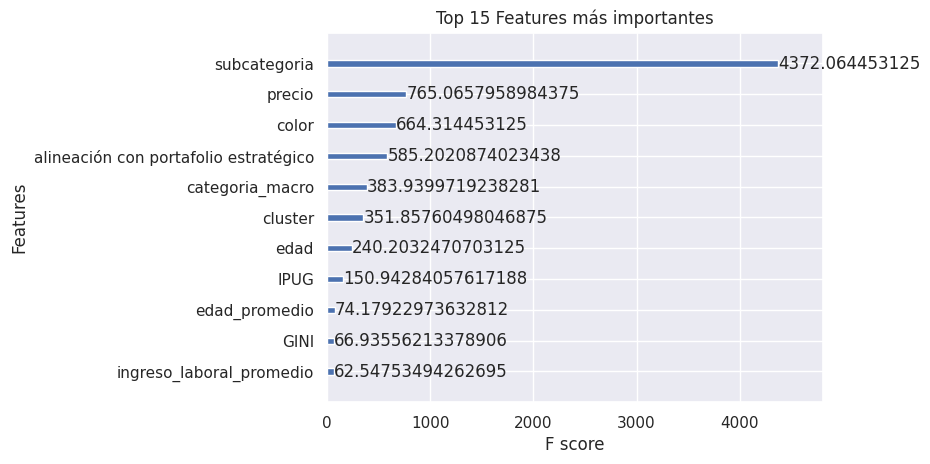

In [ ]:
#Análisis impacto de las variables usadas en el modelo
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(modelo_xgb, max_num_features=15, importance_type='gain')
plt.title("Top 15 Features más importantes")
plt.show()


In [ ]:
def recomendar_con_xgboost(cliente_id, top_n=10):
    # Productos ya comprados por el cliente
    productos_comprados = set(b2c[b2c['id'] == cliente_id]['producto'].unique())

    # Productos candidatos (no comprados)
    todos_productos = b2c['producto'].unique()
    productos_candidatos = list(set(todos_productos) - productos_comprados)

    if not productos_candidatos:
        return f"Cliente {cliente_id} ya ha comprado todos los productos."

    df_pred = pd.DataFrame({'id': cliente_id, 'producto': productos_candidatos})

    # Merge con features del usuario
    df_pred = df_pred.merge(features_usuario, on='id', how='left')

    # Merge con features del producto
    df_pred = df_pred.merge(features_producto, on='producto', how='left')

    # Tratar nulos
    df_pred.fillna("desconocido", inplace=True)

    # Reducir cardinalidad de color 
    if 'color' in df_pred.columns and df_pred['color'].nunique() > 20:
        top_colores = features_producto['color'].value_counts().nlargest(20).index
        df_pred['color'] = df_pred['color'].where(df_pred['color'].isin(top_colores), 'otros')

    # Convertir variables categóricas
    for col in ['cluster', 'categoria_macro', 'subcategoria', 'color']:
        if col in df_pred.columns:
            df_pred[col] = df_pred[col].astype('category')

    # Eliminar columnas no usadas durante el entrenamiento
    X_pred = df_pred.drop(columns=['id', 'producto'])  

    # Predecir probabilidad de compra
    probs = modelo_xgb.predict_proba(X_pred)[:, 1]

    # Construir ranking
    df_pred['score'] = probs
    top_recomendaciones = df_pred.sort_values('score', ascending=False).head(top_n)

    return top_recomendaciones[['producto', 'score']]


In [ ]:
#Ejemplo recomendacion con xgboost
recomendar_con_xgboost(cliente_id=11, top_n=10)


,producto,score
5538,producto_49,0.984358
5932,producto_19,0.983539
4530,producto_3,0.974469
7137,producto_28,0.973825
1748,producto_72,0.973797
6134,producto_112,0.973154
2275,producto_27,0.971467
400,producto_74,0.971260
666,producto_119,0.966370
1177,producto_66,0.962967


## Recomendador HIBRIDO

In [ ]:

def recomendar_hibrido(cliente_id, top_n=10, alpha=0.5):
    # Validar que cliente exista en el mapping de LightFM
    if cliente_id not in dataset.mapping()[0]:
        return f"Cliente {cliente_id} no está en el dataset de LightFM."

    # Productos ya comprados
    productos_comprados = set(b2c[b2c['id'] == cliente_id]['producto'].unique())
    productos_totales = b2c['producto'].unique()
    productos_candidatos = list(set(productos_totales) - productos_comprados)

    if not productos_candidatos:
        return f"Cliente {cliente_id} ya ha comprado todos los productos."

    # LightFM scores
    usuario_interno = dataset.mapping()[0][cliente_id]
    productos_idx = [dataset.mapping()[2][p] for p in productos_candidatos if p in dataset.mapping()[2]]
    scores_lfm = model.predict(usuario_interno, productos_idx, user_features=user_features, item_features=item_features)

    # Mapear scores a productos
    lfm_scores = pd.DataFrame({'producto': [p for p in productos_candidatos if p in dataset.mapping()[2]],
                               'score_lfm': scores_lfm})

    # XGBoost scores
    df_pred = pd.DataFrame({'id': cliente_id, 'producto': lfm_scores['producto']})
    df_pred = df_pred.merge(features_usuario, on='id', how='left')
    df_pred = df_pred.merge(features_producto, on='producto', how='left')
    df_pred.fillna("desconocido", inplace=True)

    if 'color' in df_pred.columns and df_pred['color'].nunique() > 20:
        top_colores = features_producto['color'].value_counts().nlargest(20).index
        df_pred['color'] = df_pred['color'].where(df_pred['color'].isin(top_colores), 'otros')

    for col in ['cluster', 'categoria_macro', 'subcategoria', 'color']:
        if col in df_pred.columns:
            df_pred[col] = df_pred[col].astype('category')

    X_pred = df_pred.drop(columns=['id', 'producto'])
    scores_xgb = modelo_xgb.predict_proba(X_pred)[:, 1]

    # Combinar scores
    lfm_scores['score_xgb'] = scores_xgb
    lfm_scores['score_hibrido'] = alpha * lfm_scores['score_lfm'] + (1 - alpha) * lfm_scores['score_xgb']

    # Ordenar y devolver top N
    top_recomendaciones = lfm_scores.sort_values('score_hibrido', ascending=False).head(top_n)
    return top_recomendaciones[['producto', 'score_lfm', 'score_xgb', 'score_hibrido']]


In [36]:
# Obtener recomendaciones híbridas para un cliente B2C
df_hibrido_b2c = recomendar_hibrido(cliente_id=11, top_n=20, alpha=0.5)

# Validar si se obtuvo un DataFrame o un mensaje de error
if isinstance(df_hibrido_b2c, pd.DataFrame):
    # Crear diccionario con métricas estadísticas del modelo híbrido
    metricas_hibrido_b2c = {
        "Media score híbrido": round(df_hibrido_b2c["score_hibrido"].mean(), 4),
        "Máximo score híbrido": round(df_hibrido_b2c["score_hibrido"].max(), 4),
        "Mínimo score híbrido": round(df_hibrido_b2c["score_hibrido"].min(), 4),
        "Desviación estándar": round(df_hibrido_b2c["score_hibrido"].std(), 4)
    }

    print("Métricas del modelo híbrido B2C:")
    for k, v in metricas_hibrido_b2c.items():
        print(f"- {k}: {v}")
else:
    print(f"Error: {df_hibrido_b2c}")


Métricas del modelo híbrido B2C:
- Media score híbrido: -40.71770095825195
- Máximo score híbrido: -40.6524
- Mínimo score híbrido: -40.7647
- Desviación estándar: 0.0347


In [ ]:
#Ejemplo recomendacion hibrida
recomendar_hibrido(cliente_id=2, top_n=10, alpha=0.6)


,producto,score_lfm,score_xgb,score_hibrido
5683,producto_132,-77.240265,0.919974,-45.976173
5528,producto_49,-77.307594,0.986842,-45.989822
398,producto_74,-77.308426,0.975772,-45.994747
4521,producto_3,-77.387726,0.970659,-46.044373
6123,producto_112,-77.475906,0.969773,-46.097637
1172,producto_66,-77.475945,0.962580,-46.100536
5241,producto_366,-77.476303,0.951914,-46.105019
6051,producto_242,-77.477173,0.949617,-46.106457
1083,producto_355,-77.479477,0.951914,-46.106922
1098,producto_59,-77.441803,0.891578,-46.108452


## Comparación de Modelos

In [ ]:
def comparar_modelos(cliente_id, top_n=30, alpha=0.5, normalizar_lfm=True):
    df_scores = recomendar_hibrido(cliente_id=cliente_id, top_n=top_n, alpha=alpha)

    if isinstance(df_scores, str):
        print(df_scores)
        return

    # Escalar LightFM 
    if normalizar_lfm:
        min_lfm, max_lfm = df_scores['score_lfm'].min(), df_scores['score_lfm'].max()
        df_scores['score_lfm_norm'] = (df_scores['score_lfm'] - min_lfm) / (max_lfm - min_lfm)
        df_scores['score_hibrido_norm'] = alpha * df_scores['score_lfm_norm'] + (1 - alpha) * df_scores['score_xgb']
        cols_plot = ['score_lfm_norm', 'score_xgb', 'score_hibrido_norm']
    else:
        cols_plot = ['score_lfm', 'score_xgb', 'score_hibrido']

    # Estadísticas
    print("Estadísticas de scores:")
    for col in cols_plot:
        print(f"\n{col}:")
        print(df_scores[col].describe())

    # Grafica
    df_plot = df_scores.melt(id_vars='producto', value_vars=cols_plot,
                             var_name='modelo', value_name='score')

    plt.figure(figsize=(14, 6))
    sns.barplot(data=df_plot, x='producto', y='score', hue='modelo', palette='Set2')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Comparación de scores normalizados para Cliente {cliente_id}" if normalizar_lfm else f"Comparación de scores para Cliente {cliente_id}")
    plt.ylabel("Score")
    plt.xlabel("Producto")
    plt.legend(title='Modelo')
    plt.tight_layout()
    plt.show()

    # Ranking
    df_scores['rank_lfm'] = df_scores['score_lfm'].rank(ascending=False)
    df_scores['rank_xgb'] = df_scores['score_xgb'].rank(ascending=False)
    df_scores['rank_diff'] = df_scores['rank_xgb'] - df_scores['rank_lfm']
    print("\nTop 5 mayores diferencias de ranking (XGBoost vs LightFM):")
    print(df_scores[['producto', 'rank_lfm', 'rank_xgb', 'rank_diff']].sort_values('rank_diff', key=abs, ascending=False).head())


Estadísticas de scores:

score_lfm_norm:
count    15.000000
mean      0.274392
std       0.318589
min       0.000000
25%       0.060048
50%       0.132397
75%       0.357618
max       1.000000
Name: score_lfm_norm, dtype: float64

score_xgb:
count    15.000000
mean      0.946889
std       0.039666
min       0.836422
25%       0.939305
50%       0.951914
75%       0.973216
max       0.986842
Name: score_xgb, dtype: float64

score_hibrido_norm:
count    15.000000
mean      0.543391
std       0.191805
min       0.373743
25%       0.422679
50%       0.464470
75%       0.587018
max       0.967990
Name: score_hibrido_norm, dtype: float64


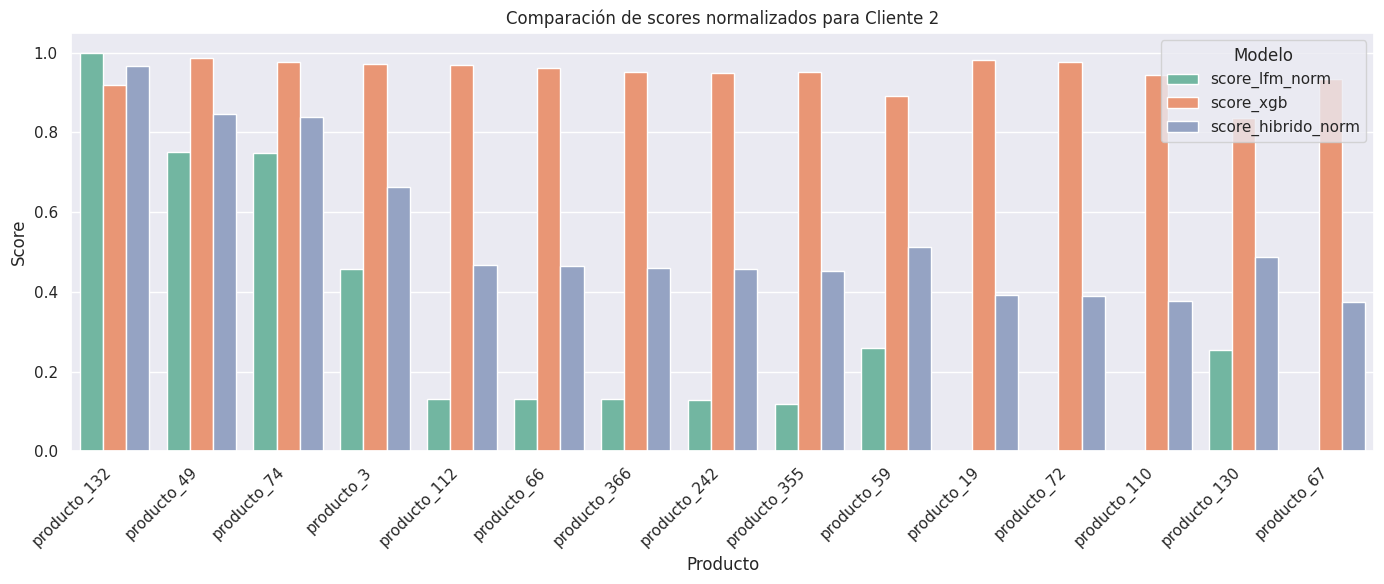


Top 5 mayores diferencias de ranking (XGBoost vs LightFM):
          producto  rank_lfm  rank_xgb  rank_diff
5683  producto_132       1.0      13.0       12.0
1742   producto_72      14.0       3.0      -11.0
5921   producto_19      12.0       2.0      -10.0
1098   producto_59       5.0      14.0        9.0
2734  producto_130       6.0      15.0        9.0


In [24]:
comparar_modelos(cliente_id=2, top_n=15, alpha=0.6)


### Exportación del modelo

Para la implementación de la interfaz

In [25]:
# import joblib
# import os

# # Crear carpeta si no existe
# os.makedirs("modelos", exist_ok=True)

# # Guardar modelos B2C
# joblib.dump(modelo_xgb, 'modelos/b2c_model_xgb.pkl')
# joblib.dump(model, 'modelos/b2c_model_lfm.pkl')
# joblib.dump(dataset, 'modelos/b2c_dataset.pkl')
# joblib.dump(user_features, 'modelos/b2c_user_features.pkl')
# joblib.dump(item_features, 'modelos/b2c_item_features.pkl')


# print("Modelos y objetos B2C guardados correctamente.")

Modelos y objetos B2C guardados correctamente.


In [26]:
# from google.colab import files
# files.download('modelos/b2c_model_xgb.pkl')
# files.download('modelos/b2c_model_lfm.pkl')
# files.download('modelos/b2c_dataset.pkl')
# files.download('modelos/b2c_user_features.pkl')
# files.download('modelos/b2c_item_features.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt


In [40]:
# Librerías
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Inputs
id_input = widgets.Text(
    value='11',
    placeholder='ID del cliente',
    description='Cliente ID:',
    disabled=False
)

topn_slider = widgets.IntSlider(
    value=10,
    min=1,
    max=30,
    step=1,
    description='Top-N:',
    continuous_update=False
)

alpha_slider = widgets.FloatSlider(
    value=0.5,
    min=0.0,
    max=1.0,
    step=0.05,
    description='Peso LFM (α):',
    continuous_update=False
)

btn = widgets.Button(description="Comparar Modelos")
output = widgets.Output()

# Lógica
def on_click(b):
    output.clear_output()
    with output:
        try:
            cliente_id = int(id_input.value)
            topn = topn_slider.value
            alpha = alpha_slider.value

            df_scores = recomendar_hibrido(cliente_id=cliente_id, top_n=topn, alpha=alpha)

            if isinstance(df_scores, str):
                print(df_scores)
                return

            # --- Normalizar LightFM ---
            min_lfm, max_lfm = df_scores['score_lfm'].min(), df_scores['score_lfm'].max()
            df_scores['score_lfm_norm'] = (df_scores['score_lfm'] - min_lfm) / (max_lfm - min_lfm)
            df_scores['score_hibrido_norm'] = alpha * df_scores['score_lfm_norm'] + (1 - alpha) * df_scores['score_xgb']

            # --- Gráfico de scores ---
            df_plot = df_scores.melt(
                id_vars='producto',
                value_vars=['score_lfm_norm', 'score_xgb', 'score_hibrido_norm'],
                var_name='modelo', value_name='score'
            )

            plt.figure(figsize=(14, 6))
            sns.barplot(data=df_plot, x='producto', y='score', hue='modelo', palette='Blues')
            plt.title(f"Comparación de scores normalizados para Cliente {cliente_id}")
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

            # --- Tabla con scores promedio ---
            df_scores['score_promedio'] = df_scores[['score_lfm', 'score_xgb']].mean(axis=1)
            tabla = df_scores[['producto', 'score_lfm', 'score_xgb', 'score_promedio']].sort_values(
                'score_promedio', ascending=False).reset_index(drop=True)

            display(tabla)

            # Imprimir métricas de cada modelo por separado
            print("\nMétricas del modelo XGBoost:")
            for k, v in metricas_xgb_b2c.items():
                print(f"{k}: {v:.4f}")

            print("\nMétricas del modelo LightFM:")
            for k, v in metricas_lfm_b2c.items():
                print(f"{k}: {v:.4f}")

            print("\nMétricas del modelo Híbrido:")
            for k, v in metricas_hibrido_b2c.items():
                print(f"{k}: {v:.4f}")

        except Exception as e:
            print(f"Error: {e}")

btn.on_click(on_click)

# Mostrar interfaz
display(widgets.VBox([
    id_input,
    topn_slider,
    alpha_slider,
    btn,
    output
]))
